<div style="text-align:center;border:2px solid black;border-radius:15px;padding:15px;font-size:20px;font-weight:bold;background-color:#2A7ADA">
    Importing Libraries</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

<div style="text-align:center;border:2px solid black;border-radius:15px;padding:15px;font-size:20px;font-weight:bold;background-color:#2A7ADA">
    Loadind Datasets</div>

In [2]:
data = pd.read_csv('breast-cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
data = data.drop(columns=['id'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

<div style="text-align:center;border:2px solid black;border-radius:15px;padding:15px;font-size:20px;font-weight:bold;background-color:#2A7ADA">
    Data Preprocessing</div>

In [4]:
def find_nulls(data:pd.DataFrame) -> pd.DataFrame:
    temp = {'columns':[],'nulls':[],'nulls_%':[],'unique':[]}
    nulls = data.isnull().sum()
    temp['columns'] = nulls.axes[0]
    temp['nulls'] = nulls.values
    temp['nulls_%'] = nulls.values*100/data.shape[0]
    for i in nulls.axes[0]:
        temp['unique'].append(data[i].unique().shape[0])
    temp = pd.DataFrame(temp)
    return temp.sort_values('nulls')
find_nulls(data).style.background_gradient(cmap='Blues')

,columns,nulls,nulls_%,unique
0,diagnosis,0,0.000000,2
28,concave points_worst,0,0.000000,492
27,concavity_worst,0,0.000000,539
26,compactness_worst,0,0.000000,529
25,smoothness_worst,0,0.000000,411
24,area_worst,0,0.000000,544
23,perimeter_worst,0,0.000000,514
22,texture_worst,0,0.000000,511
21,radius_worst,0,0.000000,457
20,fractal_dimension_se,0,0.000000,545


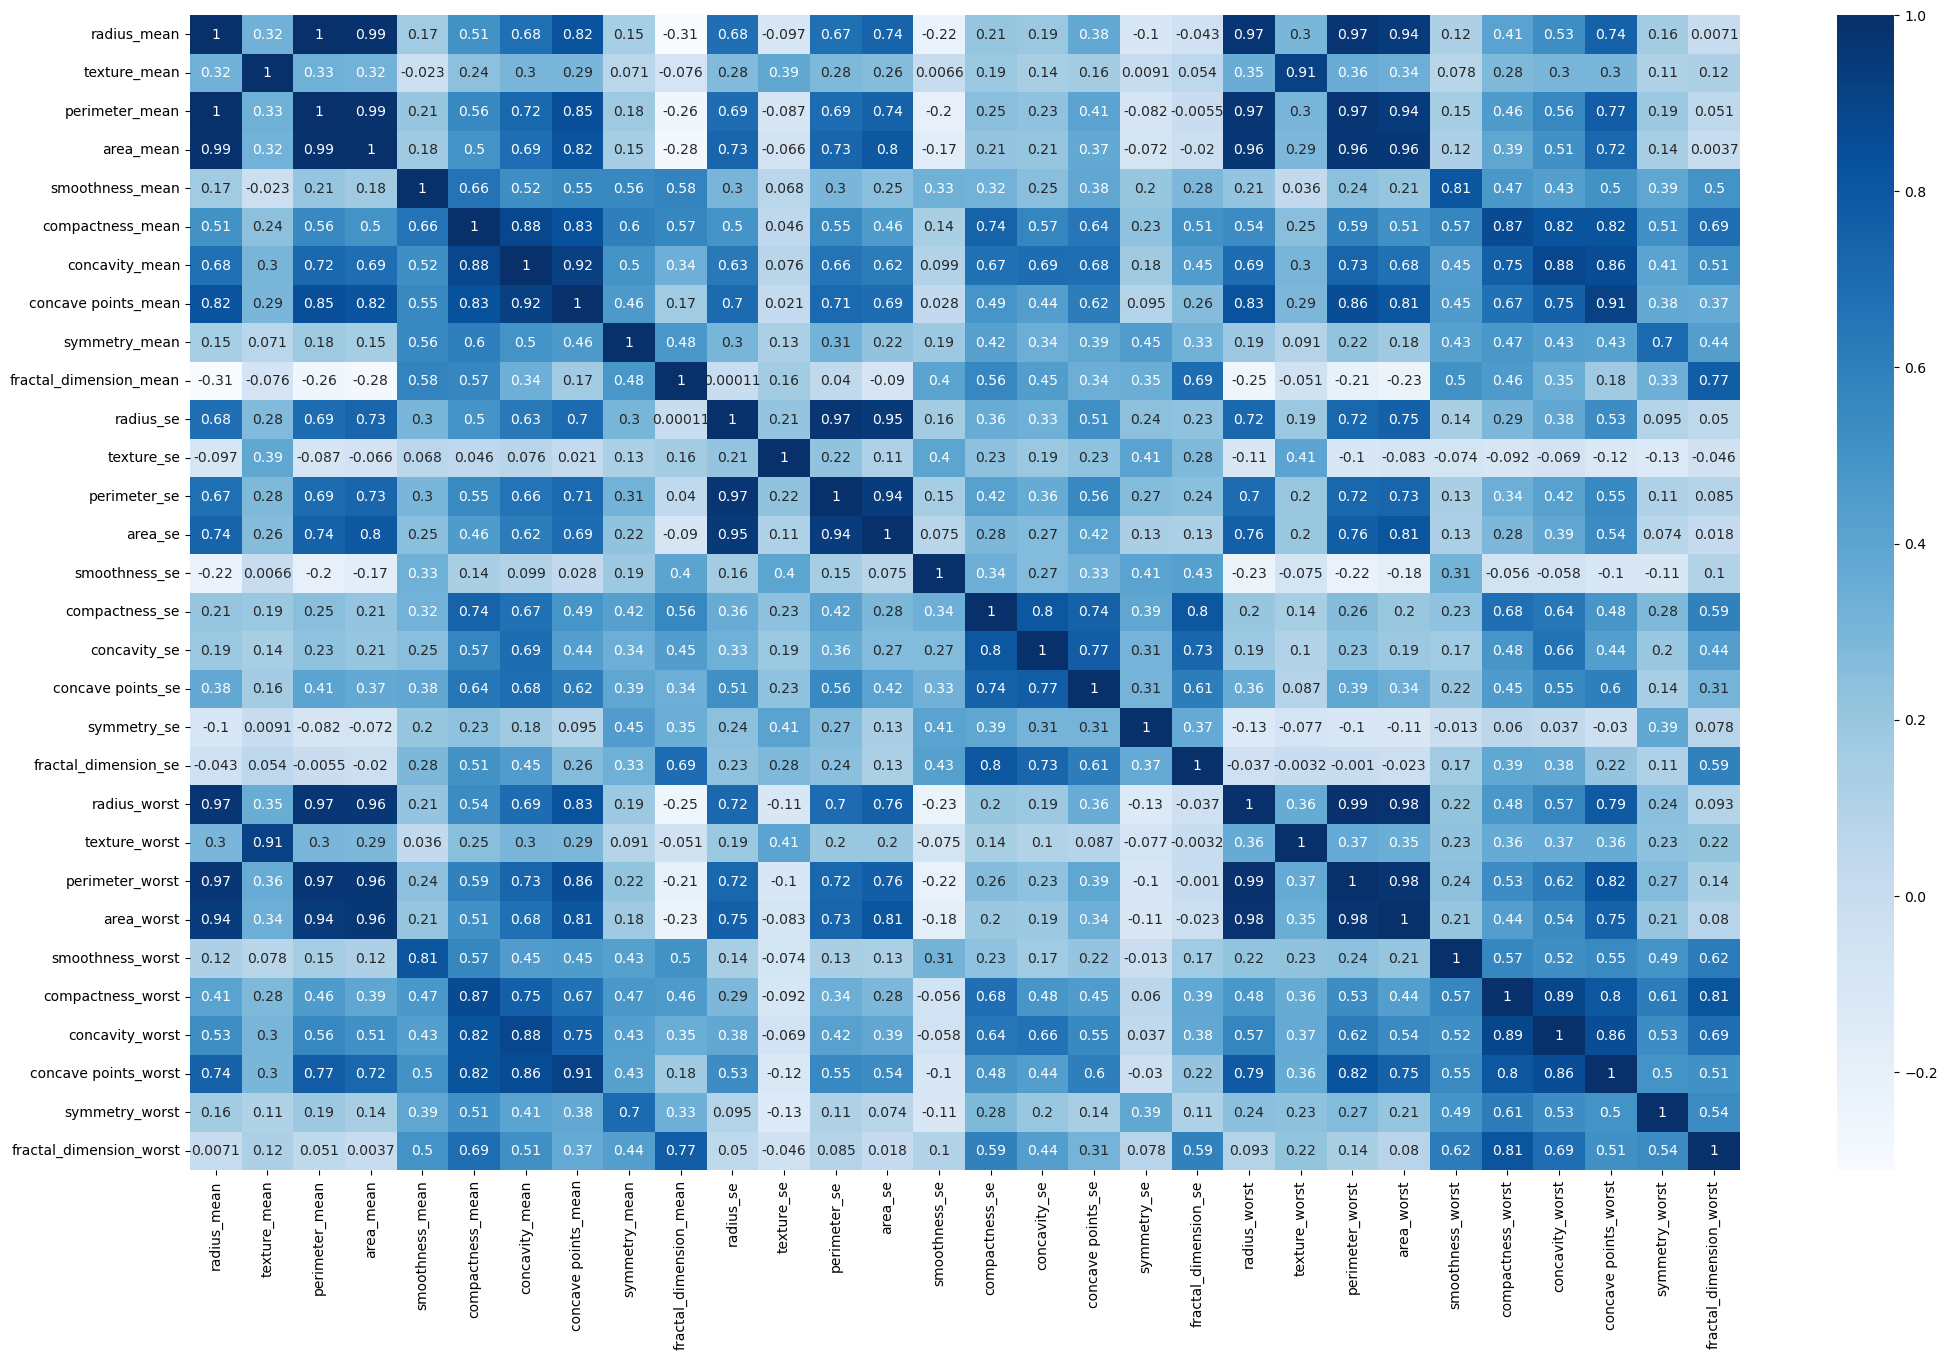

In [5]:
plt.figure(figsize=(25,15))
sns.heatmap(data.drop(columns=['diagnosis']).corr(),annot=True,cmap='Blues')
plt.show()

In [6]:
cols = ['area_mean','perimeter_mean','area_worst','perimeter_worst','perimeter_se','area_se']
def annova(data:pd.DataFrame,cols:list[str],output:str):
    for col in cols:
        SSB,SSW = 0,0
        mean = data[col].mean()
        for i in data[output].unique():
            temp = data[data[output] == i][col]
            SSB += temp.shape[0]*(mean - temp.mean())**2
            SSW += np.sum((temp-temp.mean())**2)
        db = data[output].unique().shape[0] - 1
        dw = data[col].shape[0] - data[output].unique().shape[0]
        critical = (SSB/db) / (SSW/dw)
        if critical < f.ppf(0.95,db,dw):
            print("failed to reject null hypothesis between",col,'and',output)
annova(data,data.columns.drop(cols).drop('diagnosis'),'diagnosis')

failed to reject null hypothesis between fractal_dimension_mean and diagnosis
failed to reject null hypothesis between texture_se and diagnosis
failed to reject null hypothesis between smoothness_se and diagnosis
failed to reject null hypothesis between symmetry_se and diagnosis
failed to reject null hypothesis between fractal_dimension_se and diagnosis


In [7]:
annova_cols = ['fractal_dimension_mean','texture_se','smoothness_se','symmetry_se','fractal_dimension_se']
base = RandomForestClassifier(max_features='sqrt')
base.fit(data[data.columns.drop(cols).drop('diagnosis')].to_numpy(),data['diagnosis'].to_numpy())

RandomForestClassifier()

In [8]:
feature_importance = {"columns":data.columns.drop(cols).drop('diagnosis'),"score":base.feature_importances_*100}
feature_importance = pd.DataFrame(feature_importance).sort_values('score',ascending=False)
feature_importance.style.background_gradient(cmap='Blues')

,columns,score
16,radius_worst,18.926335
21,concave points_worst,17.638394
0,radius_mean,10.676465
4,concavity_mean,8.923188
5,concave points_mean,8.453036
20,concavity_worst,7.544098
8,radius_se,5.229332
3,compactness_mean,3.283839
19,compactness_worst,2.328156
1,texture_mean,2.207959


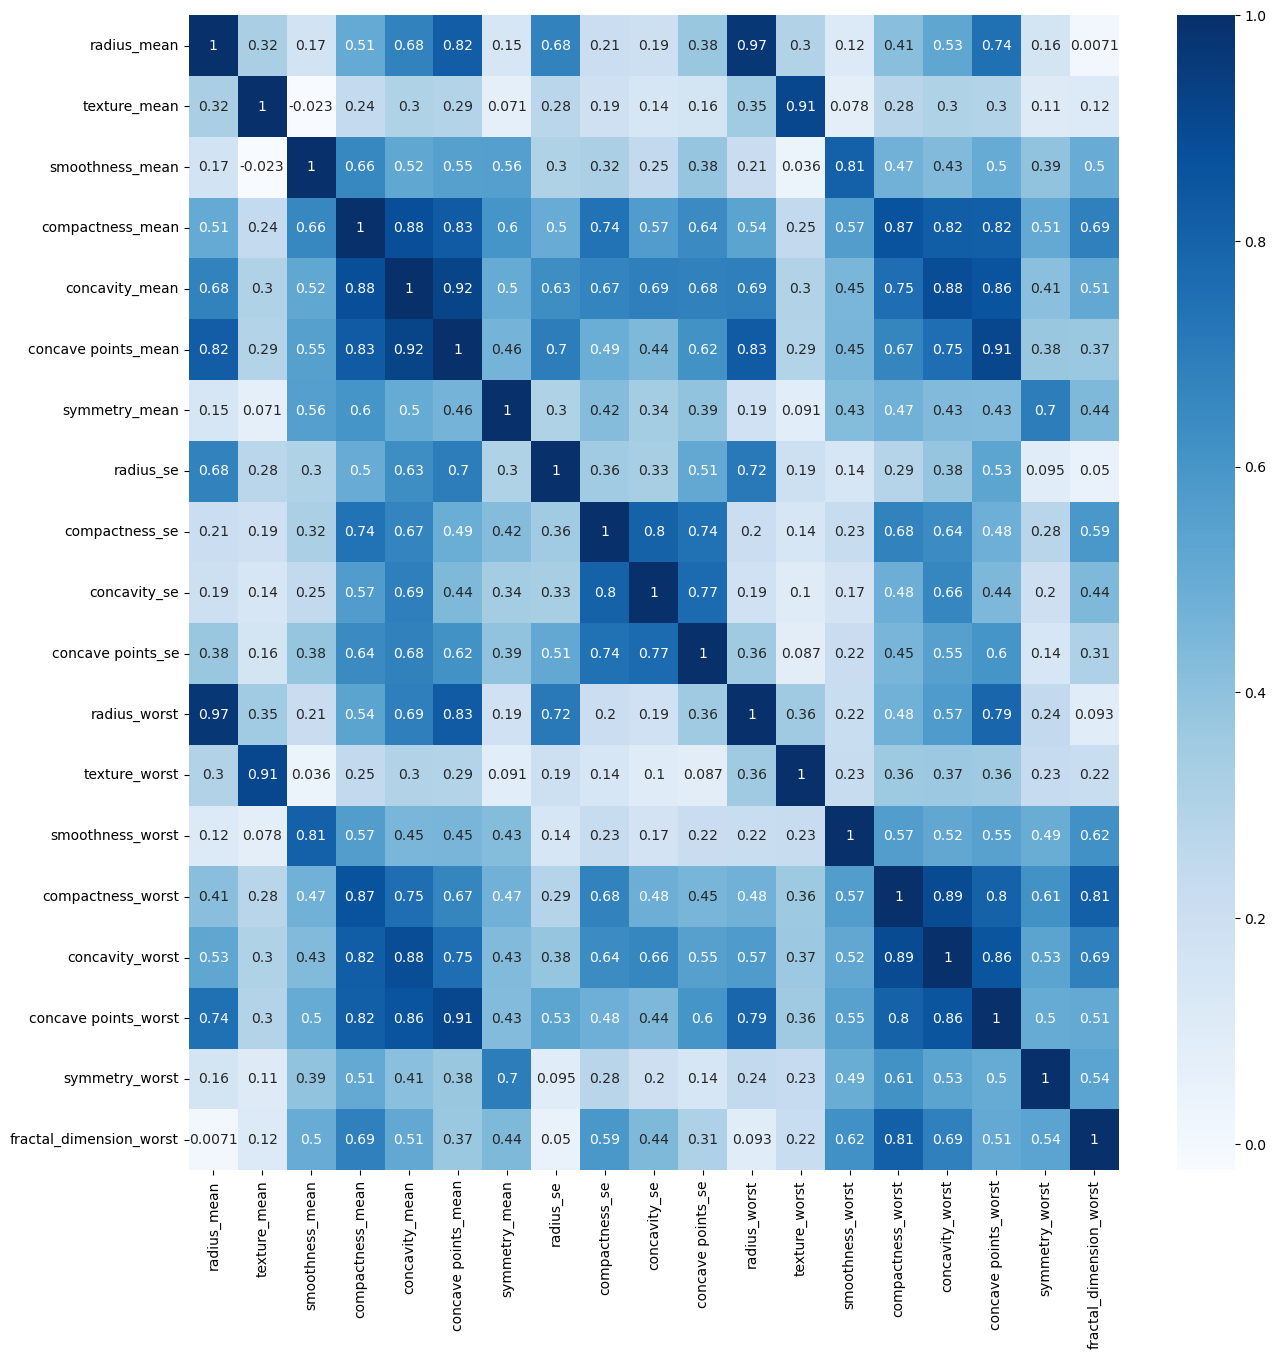

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(data[data.columns.drop(cols).drop('diagnosis').drop(annova_cols)].corr(),annot=True,cmap='Blues')
plt.show()

In [10]:
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})
x_train,x_test,y_train,y_test = train_test_split(data[data.columns.drop(cols).drop(annova_cols).drop('diagnosis')].to_numpy(),data['diagnosis'].to_numpy(),random_state=42,train_size=0.7)
x_train

array([[13.74   , 17.91   ,  0.07944, ...,  0.06019,  0.235  ,  0.07014],
       [13.37   , 16.39   ,  0.07115, ...,  0.08978,  0.2048 ,  0.07628],
       [14.69   , 13.98   ,  0.1031 , ...,  0.1108 ,  0.2827 ,  0.09208],
       ...,
       [14.29   , 16.82   ,  0.06429, ...,  0.03333,  0.2458 ,  0.0612 ],
       [13.98   , 19.62   ,  0.106  , ...,  0.1827 ,  0.3179 ,  0.1055 ],
       [12.18   , 20.52   ,  0.08013, ...,  0.07431,  0.2694 ,  0.06878]])

<div style="text-align:center;border:2px solid black;border-radius:15px;padding:15px;font-size:20px;font-weight:bold;background-color:#2A7ADA">
    Model</div>

In [11]:
class AdaBoost:
    def __init__(self,n_estimators:int) -> None:
        self.stumps = []
        self.alphas = []
        self.errors = []
        self.n_estimators = n_estimators
    def __calculate_error(self,weights:np.ndarray,y:np.ndarray,y_pred:np.ndarray):
        error = np.sum(np.not_equal(y,y_pred)*weights)/np.sum(weights)
        return error
    def __calculate_alpha(self,error:float):
        return 0.5*np.log((1-error)/(error))
    def __calculate_weights(self,weights:np.ndarray,y:np.ndarray,y_pred:np.ndarray,alpha:float):
        signs = np.not_equal(y,y_pred)
        signs = signs.astype(int)
        signs[signs == 0] = -1
        return  weights * np.exp(alpha*signs)
    def fit(self,x:np.ndarray,y:np.ndarray):
        y_temp = y.copy()
        y_temp[y_temp == 0] = -1
        self.stumps = []
        self.alphas = []
        self.errors = []
        weights = None
        alpha = None
        y_pred = None
        for i in range(self.n_estimators):
            if i == 0:
                weights = np.ones(shape=(x.shape[0],))/x.shape[0]
            else:
                weights = self.__calculate_weights(weights,y_temp,y_pred,alpha)
            stump = DecisionTreeClassifier(max_depth=1)
            stump.fit(x,y_temp,sample_weight=weights)
            y_pred = stump.predict(x)
            error = self.__calculate_error(weights,y_temp,y_pred)
            alpha = self.__calculate_alpha(error)
            self.stumps.append(stump)
            self.errors.append(error)
            self.alphas.append(alpha)
    def predict(self,x:np.ndarray):
        preds = [self.alphas[i]*self.stumps[i].predict(x) for i in range(self.n_estimators)]
        pred = np.sum(preds,axis=0)
        pred[pred >= 0] = 1
        pred[pred < 0] = 0
        return pred
    def predict_proba(self,x:np.ndarray):
        class_scores = np.zeros((x.shape[0], 2))
        for i in range(self.n_estimators):
            stump_pred = self.stumps[i].predict(x)
            class_scores[:, 1] += self.alphas[i] * (stump_pred == 1) 
            class_scores[:, 0] += self.alphas[i] * (stump_pred == -1) 
        class_probabilities = class_scores / np.sum(class_scores, axis=1, keepdims=True) 
        return class_probabilities

In [12]:
model = AdaBoost(n_estimators=150)
model.fit(x_train,y_train)
accuracy_score(y_train,model.predict(x_train))

1.0

In [13]:
accuracy_score(y_test,model.predict(x_test))

0.9883040935672515

In [14]:
skmodel = AdaBoostClassifier(n_estimators=150)
skmodel.fit(x_train,y_train)
accuracy_score(y_train,skmodel.predict(x_train))

1.0

In [15]:
accuracy_score(y_test,skmodel.predict(x_test))

0.9473684210526315

In [16]:
skRandom = RandomForestClassifier(n_estimators=150,max_features='sqrt',min_samples_split=15,max_depth=10)
skRandom.fit(x_train,y_train)
accuracy_score(y_train,skRandom.predict(x_train))

0.992462311557789

In [17]:
accuracy_score(y_test,skRandom.predict(x_test))

0.9590643274853801